In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve

## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/11 07:00:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
snapshotdate = "2024-08-01"

In [4]:
# --- Configuration ---
model_train_date_str = snapshotdate
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] = oot_period_months
config["model_train_date"] = datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] = config['model_train_date'] - timedelta(days=1)
config["oot_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)
config["train_test_end_date"] = config["oot_start_date"] - timedelta(days=1)
config["train_test_start_date"] = config["oot_start_date"] - relativedelta(months=train_test_period_months)
config["train_test_ratio"] = train_test_ratio
pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 8, 1, 0, 0),
 'model_train_date_str': '2024-08-01',
 'oot_end_date': datetime.datetime(2024, 7, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 6, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 5, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 6, 1, 0, 0)}


## get label store

In [5]:
# --- get label ---
LABEL_DIR = "/app/datamart/gold/label_store"
# Find subdirectories that look like *.parquet (folders, not files)
subfolders = sorted([os.path.join(LABEL_DIR, d) for d in os.listdir(LABEL_DIR) if d.endswith(".parquet")])

if not subfolders:
    raise FileNotFoundError(f"No label snapshot folders found in {LABEL_DIR}")

print(f"📂 Found {len(subfolders)} label snapshots")
label_store_sdf = spark.read.parquet(*subfolders)
print("✅ row_count:", label_store_sdf.count())
    
label_store_sdf.show(5)

# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))
print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])


📂 Found 24 label snapshots


✅ row_count: 11459


+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_1mob|   2024-09-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    0|30dpd_1mob|   2024-09-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_1mob|   2024-09-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 5 rows



[Stage 5:>                                                          (0 + 8) / 8]

extracted labels_sdf 6927 2023-06-01 00:00:00 2024-07-31 00:00:00


## get features

In [6]:
# --- get features ---
FEATURE_DIR = "/app/datamart/gold/feature_store"
subfolders = sorted([os.path.join(FEATURE_DIR, d) for d in os.listdir(FEATURE_DIR) if d.startswith("snapshot_date=")])

if not subfolders:
    raise FileNotFoundError(f"No snapshot_date folders found in {FEATURE_DIR}")

print(f"📂 Found {len(subfolders)} feature snapshots")
features_store_sdf = spark.read.parquet(*subfolders)
print("✅ row_count:", features_store_sdf.count())

features_store_sdf.show(5)

# extract feature store
try:
    features_sdf = features_store_sdf.filter(
        (col("snapshot_date") >= config["train_test_start_date"]) &
        (col("snapshot_date") <= config["oot_end_date"])
    )
except Exception as e:
    print(f"⚠️ Using application_date instead of snapshot_date due to: {e}")
    features_sdf = features_store_sdf.filter(
        (col("application_date") >= config["train_test_start_date"]) &
        (col("application_date") <= config["oot_end_date"])
    )
    
print("extracted features_sdf", features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

📂 Found 25 feature snapshots


✅ row_count: 12500
+-----------+----------------+-------------+----------------+------------------+-----------+----------------------+-------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------+-------------------+---------------+--------------+----------------------+--------------------------------+--------------------------+-----------------------------+--------------------------+-------------------------+------------------------------------+------------------------+-------------+----------------+--------------+--------------+--------------+--------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+------

[Stage 13:=========================================>                (5 + 2) / 7]

extracted features_sdf 6911 2023-06-01 00:00:00 2024-07-31 00:00:00


## prepare data for modeling

In [7]:
# --- Prepare training data ---
data_pdf = labels_sdf.join(features_sdf, on=["Customer_ID"], how="inner").toPandas()

oot_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["oot_start_date"].date()) &
    (data_pdf['snapshot_date'] <= config["oot_end_date"].date())
]
train_test_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) &
    (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())
]

In [8]:
# split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]

feature_cols = [fe_col for fe_col in data_pdf.columns if fe_col.startswith('fe_')]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 4333
X_test 1084
X_oot 989
y_train 4333 0.05
y_test 1084 0.05
y_oot 989 0.06


,fe_1_sum_all,fe_2_sum_all,fe_3_sum_all,fe_4_sum_all,fe_5_sum_all,fe_6_sum_all,fe_7_sum_all,fe_8_sum_all,fe_9_sum_all,fe_10_sum_all,...,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20
2946,1177,1129,777,1362,1535,1060,1345,1042,1723,2204,...,151,208,143,70,194,202,201,187,-109,127
3694,1230,1246,1071,1405,870,854,1208,1626,1022,1612,...,-36,107,-45,62,145,230,106,205,-69,85
2147,1637,1403,769,1173,1151,963,1855,1018,1086,908,...,100,184,37,86,226,6,6,240,193,142
395,1828,1081,1840,1530,1610,1449,1732,1889,1544,1559,...,-13,92,-17,269,50,106,169,-13,-154,63
4681,1245,810,774,1010,643,567,620,1390,1021,1228,...,178,-96,166,62,269,15,159,52,47,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,1031,1249,1086,1201,1333,1405,1170,1328,1224,1440,...,95,112,37,107,80,-32,27,-99,-2,166
791,1716,1720,1102,1944,1417,1614,1845,2063,1706,1894,...,109,47,102,82,182,174,-65,81,160,-113
225,2242,1260,1822,1874,1436,1398,1839,1103,1232,2270,...,-7,76,112,-83,-140,60,144,-98,72,250
3794,1097,1617,984,1385,913,1285,1468,731,1533,1001,...,59,-13,101,58,97,196,-4,244,152,-5


## preprocess data

In [9]:
# set up standard scalar preprocessing
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(X_train) # Q which should we use? train? test? oot? all?

# transform data
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])

pd.DataFrame(X_train_processed)

X_train_processed 4333
X_test_processed 1084
X_oot_processed 989


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.118939,-0.012728,-0.766583,0.394838,0.715173,-0.177881,0.336874,-0.375829,0.926398,1.761985,...,0.501158,1.087084,0.415760,-0.281570,0.943680,1.030658,0.995395,0.813094,-2.035088,0.266112
1,0.233997,0.236073,-0.153272,0.482794,-0.645994,-0.614821,0.053139,0.823245,-0.478222,0.608988,...,-1.372256,0.075623,-1.458661,-0.360448,0.457992,1.313097,0.049992,0.991048,-1.643346,-0.127029
2,1.117557,0.569935,-0.783272,0.008243,-0.070824,-0.383625,1.393117,-0.425106,-0.349983,-0.762143,...,-0.009773,0.846737,-0.641094,-0.123815,1.260864,-0.946409,-0.945169,1.337068,0.922565,0.406519
3,1.532200,-0.114801,1.450932,0.738478,0.868688,0.647212,1.138376,1.363238,0.567729,0.505764,...,-1.141836,-0.074594,-1.179492,1.680518,-0.483647,0.062299,0.676944,-1.164164,-2.475798,-0.332959
4,0.266560,-0.691085,-0.772841,-0.325169,-1.110632,-1.223566,-1.164646,0.338687,-0.480226,-0.138902,...,0.771651,-1.957315,0.645077,-0.360448,1.687079,-0.855626,0.577428,-0.521555,-0.507294,0.144425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4328,-0.198014,0.242453,-0.121981,0.065517,0.301706,0.553885,-0.025562,0.211389,-0.073467,0.273996,...,-0.059864,0.125695,-0.641094,0.083240,-0.186287,-1.329718,-0.736185,-2.014385,-0.987178,0.631170
4329,1.289059,1.244039,-0.088603,1.585305,0.473643,0.997188,1.372406,1.720496,0.892335,1.158220,...,0.080391,-0.525245,0.006977,-0.163253,0.824736,0.748220,-1.651733,-0.234852,0.599378,-1.980404
4330,2.430957,0.265845,1.413383,1.442122,0.512533,0.539038,1.359980,-0.250583,-0.057437,1.890529,...,-1.081727,-0.234826,0.106680,-1.790111,-2.366926,-0.401707,0.428154,-2.004498,-0.262455,1.417451
4331,-0.054734,1.025008,-0.334762,0.441884,-0.557978,0.299358,0.591615,-1.014377,0.545688,-0.581013,...,-0.420522,-1.126114,-0.002994,-0.399887,-0.017783,0.970136,-1.044685,1.376613,0.521029,-0.969472


## train model

In [18]:
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=88)

# Define the hyperparameter space to search
param_dist = {
    'n_estimators': [25, 50],
    'max_depth': [2, 3],  # lower max_depth to simplify the model
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Create a scorer based on AUC score
auc_scorer = make_scorer(roc_auc_score)

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=10,  # Number of iterations for random search
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the random search
random_search.fit(X_train_processed, y_train)

# Output the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Evaluate the model on the train set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

# Evaluate the model on the oot set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
print("Test GINI score: ", round(2*test_auc_score-1,3))
print("OOT GINI score: ", round(2*oot_auc_score-1,3))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 25, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best AUC score:  0.5
Train AUC score:  0.8304071830740092
Test AUC score:  0.6807256700661098
OOT AUC score:  0.7496705820344853
TRAIN GINI score:  0.661
Test GINI score:  0.361
OOT GINI score:  0.499


In [20]:
# --- Evaluate ---
def eval_auc(X, y):
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred_proba)
    return auc, round(2 * auc - 1, 3)

train_auc, train_gini = eval_auc(X_train_processed, y_train)
test_auc, test_gini = eval_auc(X_test_processed, y_test)
oot_auc, oot_gini = eval_auc(X_oot_processed, y_oot)

print("Train AUC:", train_auc, "GINI:", train_gini)
print("Test AUC:", test_auc, "GINI:", test_gini)
print("OOT AUC:", oot_auc, "GINI:", oot_gini)

Train AUC: 0.8304071830740092 GINI: 0.661
Test AUC: 0.6807256700661098 GINI: 0.361
OOT AUC: 0.7496705820344853 GINI: 0.499


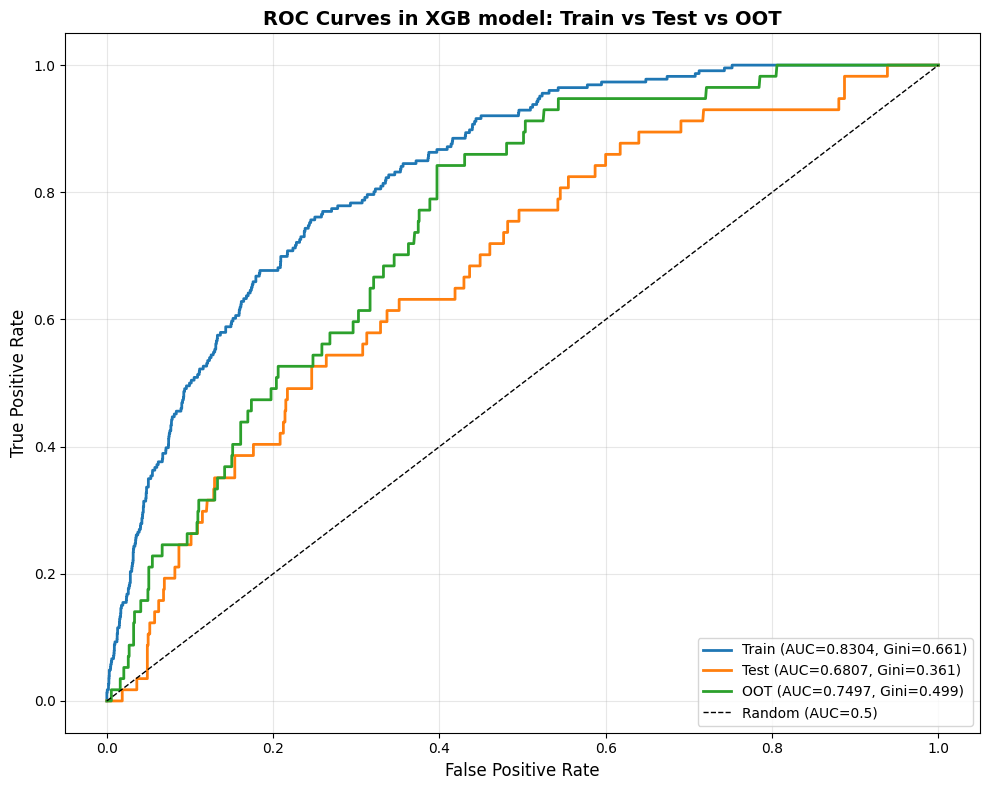

In [23]:
# ============================================
# 2. ROC CURVES (Train/Test/OOT on same plot)
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))

# Train ROC
y_train_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
ax.plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.4f}, Gini={train_gini:.3f})', linewidth=2)

# Test ROC
y_test_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
ax.plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.4f}, Gini={test_gini:.3f})', linewidth=2)

# OOT ROC
y_oot_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
fpr_oot, tpr_oot, _ = roc_curve(y_oot, y_oot_pred_proba)
ax.plot(fpr_oot, tpr_oot, label=f'OOT (AUC={oot_auc:.4f}, Gini={oot_gini:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves in XGB model: Train vs Test vs OOT', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_XGB.png', dpi=300, bbox_inches='tight')
plt.show()

## prepare model artefact to save

In [ ]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_score
model_artefact['results']['auc_test'] = test_auc_score
model_artefact['results']['auc_oot'] = oot_auc_score
model_artefact['results']['gini_train'] = round(2*train_auc_score-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_score-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_score-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

## save artefact to model bank

In [ ]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [ ]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")


## test load pickle and make model inference

In [ ]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")